# Predicting House Prices in Ames, Iowa

The goal of this analysis is to create a machine learning model that can predict what the sale price of a given house in Ames, Iowa will be depending on data about the house. To get started, let's load in our libraries and data and take a look at what we're working with:

In [1]:
# Suppress FutureWarnings    NOTE: Get rid of this line once project is finished
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load in libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load in data
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Aggregate and inspect total data
td = pd.concat([train, test], ignore_index = True, sort = False)
print(td.head())
print(td.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

Looking at our data, we have a huge variety of features to work with. This means that we have a lot of analysis to do before beginning to build our model. Let's begin with missing values.

# Section 1 - Missing Values

Before we dig into an exploratory analysis, we need to deal with the missing values. Let's create a heatmap to get a quick glance at all the missing values:

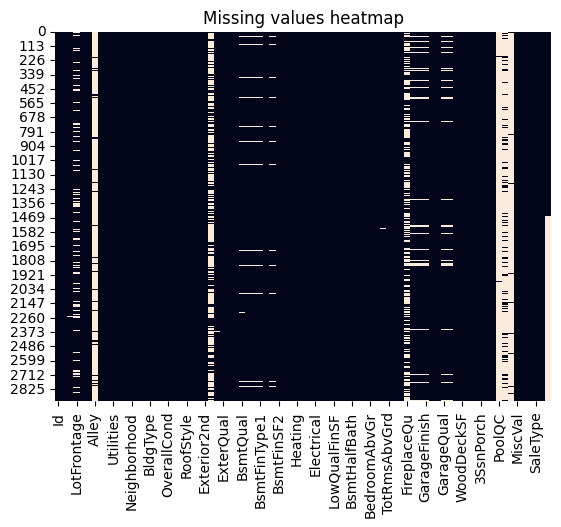

Missing value percentages:
PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
MasVnrType      60.50
                ...  
1stFlrSF         0.00
2ndFlrSF         0.00
LowQualFinSF     0.00
GrLivArea        0.00
HeatingQC        0.00
Length: 81, dtype: float64


In [2]:
# Missing values heatmap
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")
plt.show()

# Print proportions of missing values
print("Missing value percentages:")
print(round((td.isna().sum() / 2919 * 100).sort_values(ascending = False), 2))

Looking at the above output, we can safely drop the `PoolQC`, `MiscFeature`, `Alley`, and `Fence` features. With less than 20% of the observations having data in these columns, we can safely drop them from our dataset:

In [3]:
# Drop columns with most missing values
td = td.drop(columns = ['PoolQC', 'MiscFeature', 'Alley', 'Fence'])
print(td.info())

# Print new top columns with most missing values
print("Missing value percentages:")
print(round((td.isna().sum() / 2919 * 100).sort_values(ascending = False), 2))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 77 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle     2919 non-null   object 
 16  OverallQual    2919 non-null   int64  
 17  OverallCond    2919 non-null   int64  
 18  YearBuil

Looking at the new output, we can see that the top missing features are `MasVnrType` (masonry veneer type) and `FireplaceQu` (fireplace quality). For each one, we can see from the output of `value_counts()` that they both have modes that are much more frequent than other options. To fix these columns, we'll fill all missing values with the mode of each feature:

In [4]:
# Print value counts for both features
print(td['MasVnrType'].value_counts())
print(td['FireplaceQu'].value_counts())

# Replace NA's with mode for both features
for feat in ['MasVnrType', 'FireplaceQu']:
    td[[feat]] = td[[feat]].fillna(td[feat].mode()[0])

MasVnrType
BrkFace    879
Stone      249
BrkCmn      25
Name: count, dtype: int64
FireplaceQu
Gd    744
TA    592
Fa     74
Po     46
Ex     43
Name: count, dtype: int64


Now that we've fixed our columns with the largest amount of missing values, let's look at our heatmap and statistics again:

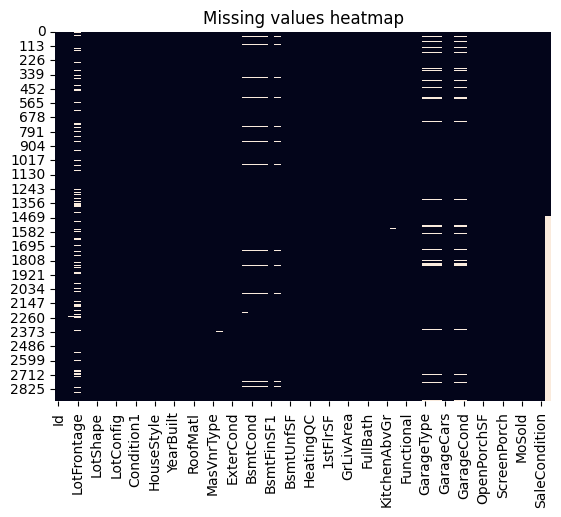

Missing value percentages:
SalePrice       49.98
LotFrontage     16.65
GarageCond       5.45
GarageYrBlt      5.45
GarageFinish     5.45
GarageQual       5.45
GarageType       5.38
BsmtExposure     2.81
BsmtCond         2.81
BsmtQual         2.77
BsmtFinType2     2.74
BsmtFinType1     2.71
MasVnrArea       0.79
MSZoning         0.14
Functional       0.07
BsmtHalfBath     0.07
BsmtFullBath     0.07
Utilities        0.07
Exterior2nd      0.03
BsmtFinSF2       0.03
dtype: float64


In [5]:
# Missing values heatmap
sns.heatmap(td.isnull(), cbar = False).set_title("Missing values heatmap")
plt.show()

# Print proportions of missing values
print("Missing value percentages:")
print(round((td.isna().sum() / 2919 * 100).sort_values(ascending = False).head(20), 2))

Observing the above output, the `SalePrice` missing values are due to the aggregation of the training and testing data. For the `LotFrontage` feature, we can simply look at the distribution of the variable, and then either impute the mean or median depending on the skewness of the distribution:

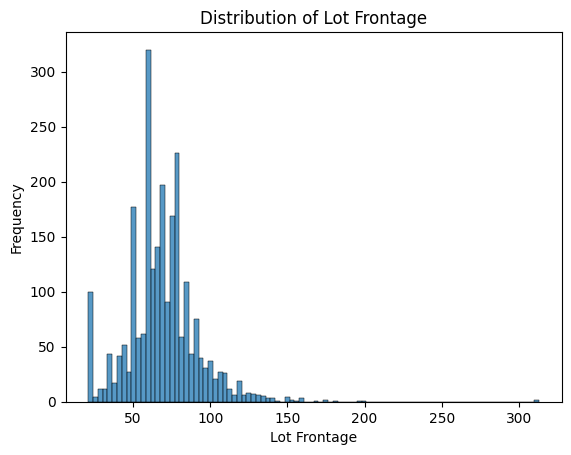

In [6]:
# Check distribution of LotFrontage
sns.histplot(data = td, x = 'LotFrontage')
plt.title("Distribution of Lot Frontage")
plt.ylabel('Frequency')
plt.xlabel('Lot Frontage')
plt.show()

# Impute median for missing values
med = td['LotFrontage'].median()
td[['LotFrontage']] = td[['LotFrontage']].fillna(med)

Since there's some large outliers in the `LotFrontage` distribution, we decided to impute the median for missing values. Since all remaining features only have about 5% or less of their observations missing, we will move onto the exploratory data analysis phase, and deal with missing features further when we get to the data engineering phase if needed.

# Section 2 - Exploratory Data Analysis / Feature Engineering

Now, we're ready to move onto the analysis phase. The biggest difficulty in this phase will be working with the huge number of features this dataset has. To make things a little easier, let's create two variables that contain lists of all the numeric and categorical variables in the dataset. (ignoring our prediction target, SalePrice)

In [7]:
# List all numeric/categorical features in two lists
numeric = td.select_dtypes(include=np.number).columns.tolist()
categorical = td.select_dtypes(exclude=np.number).columns.tolist()

# Check lists
print("Numeric features: ", numeric)
print("\n")
print("Categorical features: ", categorical)

Numeric features:  ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


Categorical features:  ['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 

# Continuous Feature Analysis

Now we can do some large-scale feature analysis. We'll start with our continuous features. First, we must narrow down which features are the most important for predicting a house's `SalePrice`. First, let's create a correlation matrix of all of our numeric variables, removing ones that have a correlation of less than 2% in the positive or negative direction:

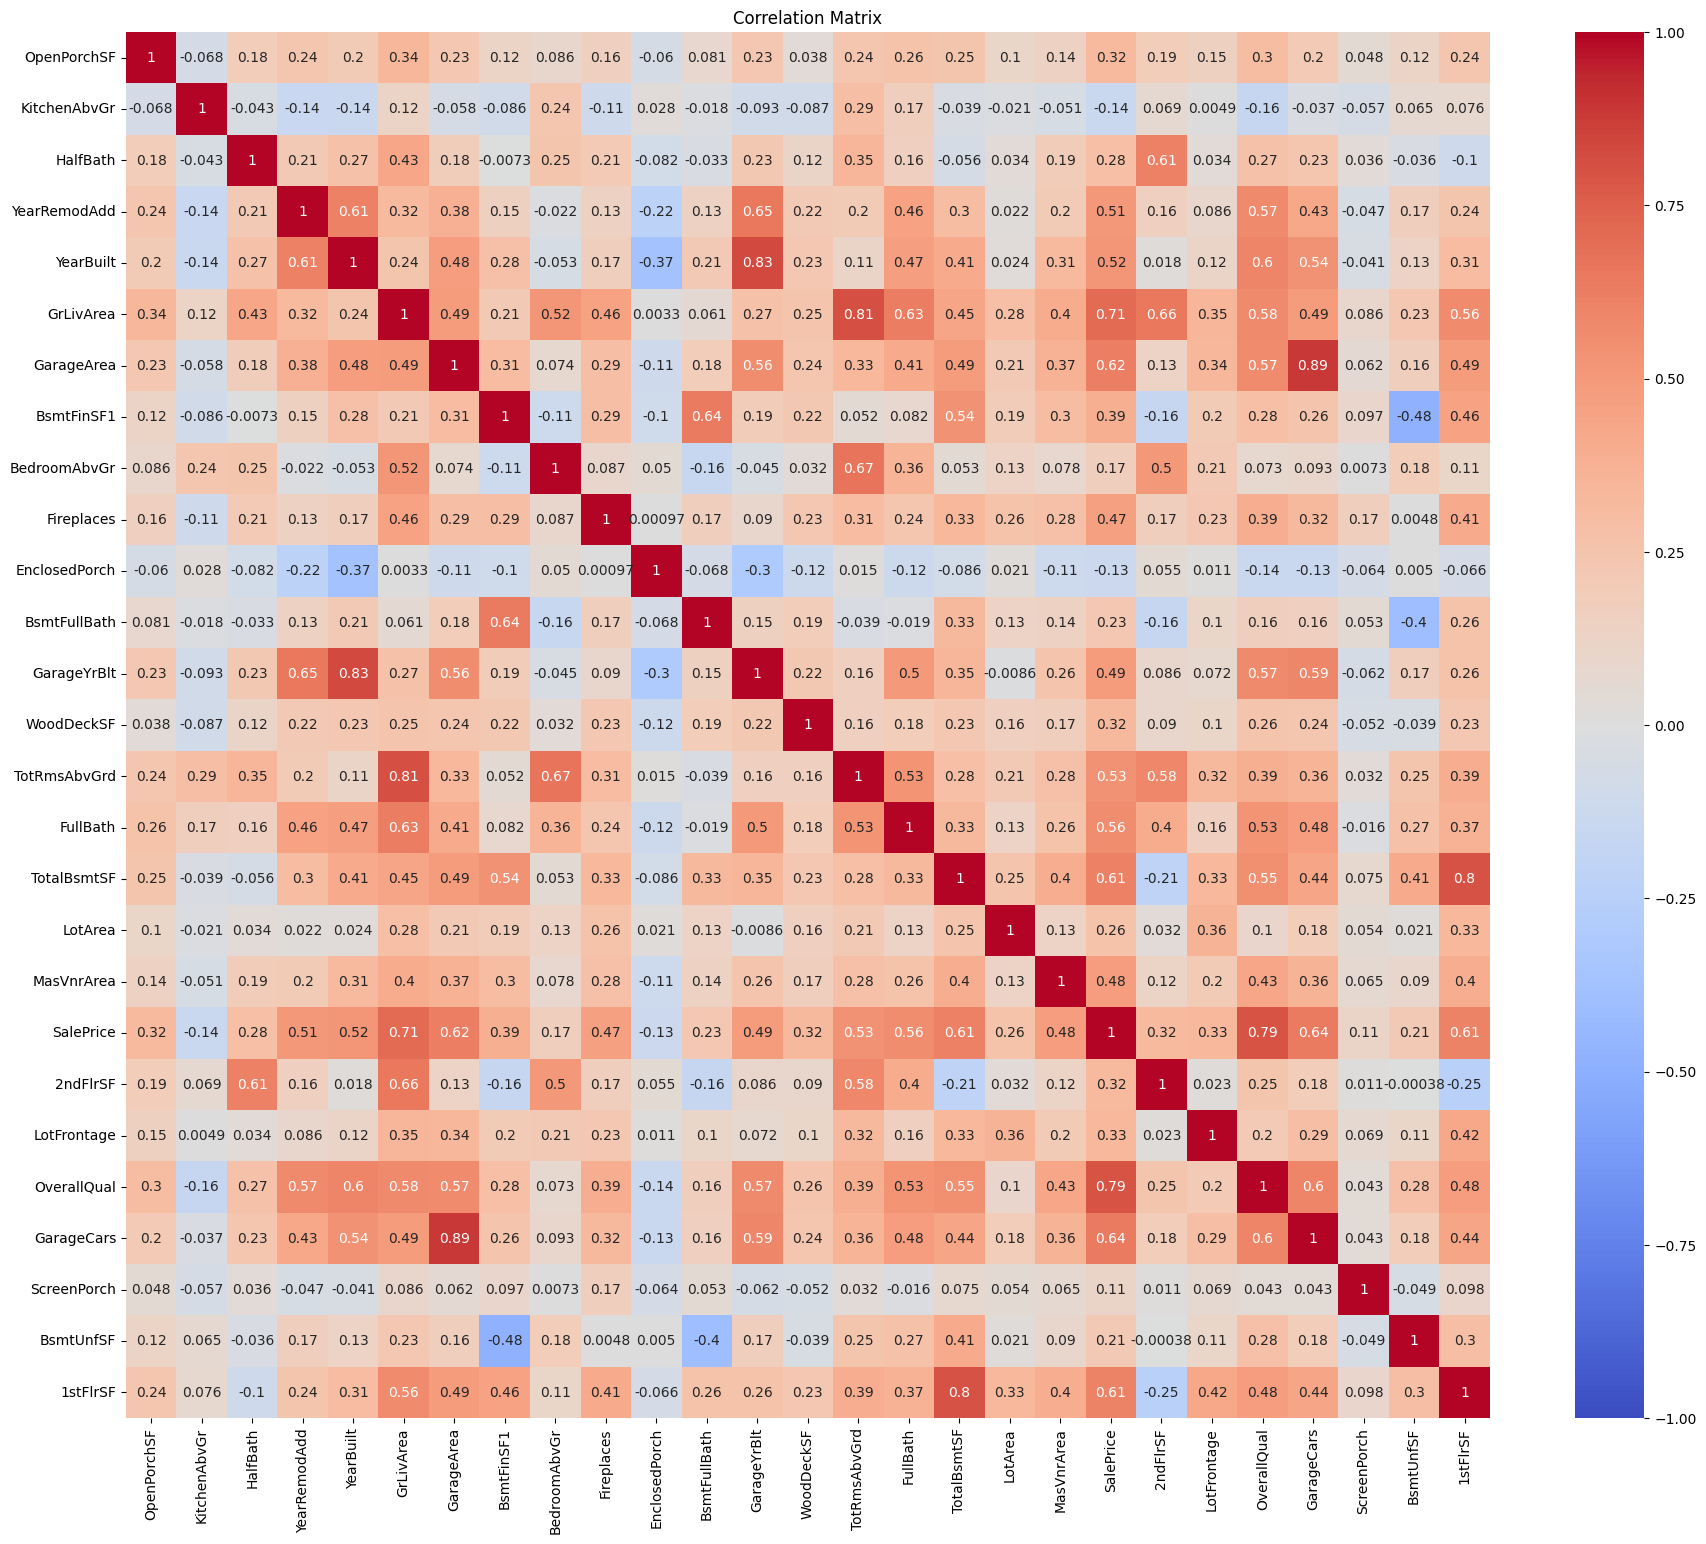

In [8]:
# Drop columns unimportant to SalePrice
to_remove = ['Id', 'MSSubClass', 'OverallCond', 'BsmtFinSF2', 'LowQualFinSF', 'BsmtHalfBath', '3SsnPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
numeric = list(set(numeric) - set(to_remove))
    
# Calculating Pearson correlation
corr_matrix = td[numeric].corr()

# Increase the figure size
plt.figure(figsize=(22, 18))

# Plotting the heatmap
sns.heatmap(corr_matrix, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

The above output makes it much clearer which continuous features affect `SalePrice` the most. The most significant continuous features that correlate with `SalePrice` are:

1. `OverallQual` (corr = 0.79) - The overall finish and material quality of the house. Ranked between 1 (very poor) and 10 (very excellent).  
2. `GrLivArea` (corr = 0.71) - The total square footage of living area above ground. (most simple estimation of a home's square footage)
3. `GarageCars` (corr = 0.64) - Size of garage in terms of car capacity.
4. `GarageArea` (corr = 0.62) - Size of garage in terms of square footage.
5. `TotalBsmtSF` (corr = 0.61) - Size of entire basement in square feet.
6. `FullBath` (corr = 0.56) - Number of full bathrooms above ground.
7. `TotRmsAbvGrd` (corr = 0.53) - Total number of rooms above ground.
8. ` YearBuilt` (corr = 0.52) - The year the house was built in.
9. `YearRemodAdd` (corr = 0.51) - The year the house was remodeled in.

All nine of the above features have a positive correlation of at least 51%. We will primarily focus on these features for the numeric side of our model. Let's plot a histogram of each feature to get an overall view of their distributions:

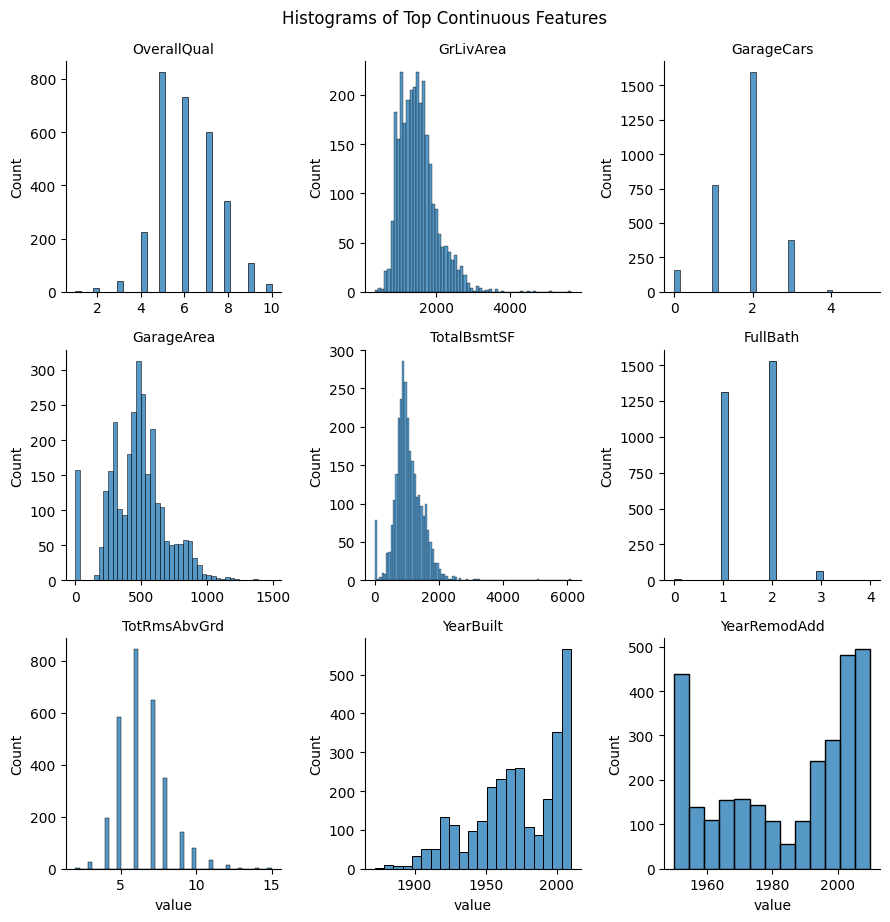

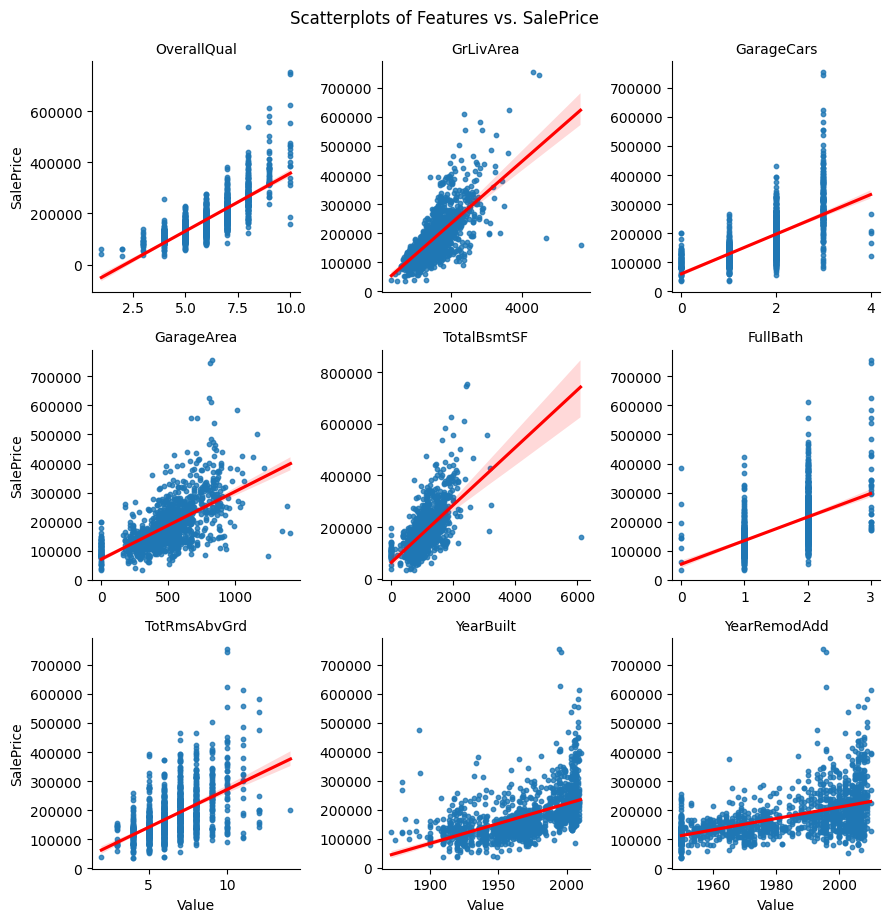

In [9]:
# Narrow down selected columns
top_numeric_features = ['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt', 'YearRemodAdd']

# Melt the DataFrame into long-format
td_melted_num = td.melt(value_vars=top_numeric_features, var_name="variable", value_name="value")

# Plot histograms of all continuous features
g = sns.FacetGrid(td_melted_num, col_wrap=3, col="variable", sharex=False, sharey=False)
g.map_dataframe(sns.histplot, x="value")
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Histograms of Top Continuous Features', y=1.02)  # Adjust y for the title to fit and not overlap with plots
plt.show()

# Plot scatterplots of all features vs. SalePrice
td_melted_num_scatter = td.melt(id_vars=['SalePrice'], value_vars = top_numeric_features, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted_num_scatter, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.regplot, 'Value', 'SalePrice', scatter_kws={"s": 10}, line_kws={"color": "red"})
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. SalePrice', y=1.02)
plt.show()

We can make one important observation using the output above. A couple of the features seem to have a quadratic relationship with `SalePrice`, specifically `YearBuilt` and `OverallQual`. Let's verify this by plotting both scatterplots with quadratic regressions instead:

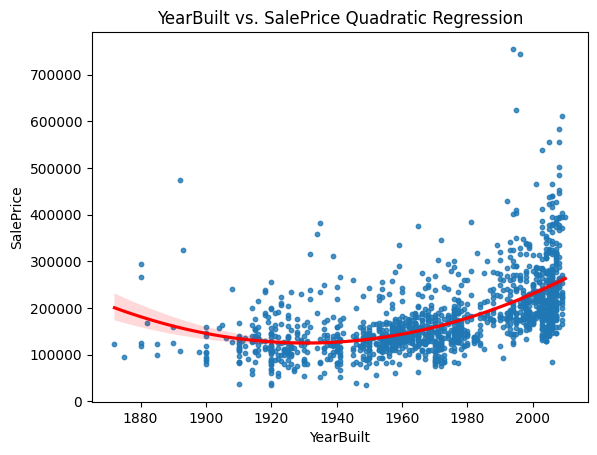

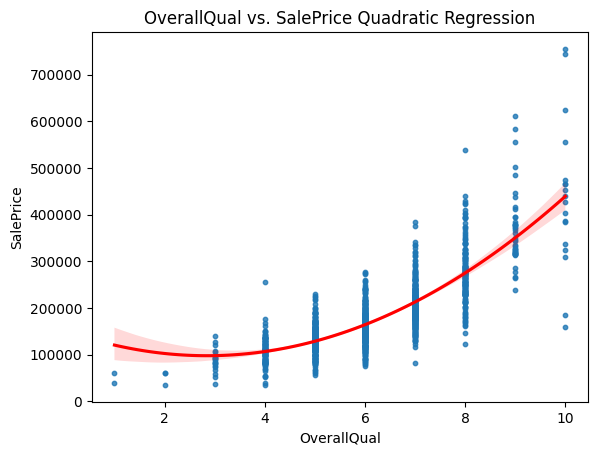

In [10]:
# Plot YearBuilt vs. SalePrice
sns.regplot(data = td, x = 'YearBuilt', y = 'SalePrice', order = 2, scatter_kws = {"s": 10}, line_kws = {"color": "red"})
plt.title('YearBuilt vs. SalePrice Quadratic Regression')
plt.show()

# Plot OverallQual vs. SalePrice
sns.regplot(data = td, x = 'OverallQual', y = 'SalePrice', order = 2, scatter_kws = {'s': 10}, line_kws = {'color': 'red'})
plt.title('OverallQual vs. SalePrice Quadratic Regression')
plt.show()

Based on the above output, I believe `YearBuilt` does have a quadratic relationship with `SalePrice`, but `OverallQual` does not. This makes sense for the year a house was built. Very old houses are often priced higher due to being more 'antique,' which is something certain people specifically want for their home. So it makes sense that older houses would often have higher prices than expected. To capture this relationship, let's use a polynomial transformation on `YearBuilt` to add a feature for the quadratic $x^2$ term:

In [11]:
# Import polynomial features from Scikit-Learn
from sklearn.preprocessing import PolynomialFeatures

# Perform polynomial transformation on YearBuilt column
years_built = td[['YearBuilt']].values
poly = PolynomialFeatures(degree=2)   # Degree 2 for quadratic relationship
years_built_poly = poly.fit_transform(years_built)

# Add the squared term into our DataFrame
td['YearBuiltSquared'] = years_built_poly[:, 2]
print(years_built_poly)

[[1.000000e+00 2.003000e+03 4.012009e+06]
 [1.000000e+00 1.976000e+03 3.904576e+06]
 [1.000000e+00 2.001000e+03 4.004001e+06]
 ...
 [1.000000e+00 1.960000e+03 3.841600e+06]
 [1.000000e+00 1.992000e+03 3.968064e+06]
 [1.000000e+00 1.993000e+03 3.972049e+06]]


Now that we have a general idea as to which continuous variables are the most important in our dataset, let's move over to the categorical features.

## Categorical Feature Analysis

Now, let's do the same facet-grid style analysis of our categorical features. Before inspecting the distributions of our categorical features, let's use ANOVA tests to narrow down which features have statistically significant differences related to `SalePrice`:

In [12]:
# Import libraries for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols   # Ordinary Least Squares for ANOVA

# Custom ANOVA method that can return whether the result is significant
def perform_significant_anova(dataframe, target, feature):
    # Construct the formula and fit the OLS model
    formula = f'{target} ~ C({feature})'
    model = ols(formula, data=dataframe).fit()
    
    # Perform ANOVA
    anova_results = sm.stats.anova_lm(model, typ=2)
    
    # Extract the p-value and test if p < 0.05
    p_value = anova_results['PR(>F)'][0]  
    f_stat = anova_results['F'][0] 
    significant = p_value < 0.05 and f_stat > 100.0   # Only select sufficiently high F-statistics and sufficiently low p-values
    
    # Return results with a significance flag
    return anova_results, significant

# Initialize empty dictionary to contain ANOVA output
anova_summary = {}
top_categorical_features = []

# Perform ANOVA for all categorical features
for feature in categorical:
    results, is_significant = perform_significant_anova(td, 'SalePrice', feature)
    anova_summary[feature] = {'ANOVA Results': results, 'Is Significant': is_significant}
    
    # Print results
    print(f"ANOVA results for {feature}:\n{results}\n")
    print(f"Is the difference in {feature} statistically significant? {'Yes' if is_significant else 'No'}\n")
    
    # Add to top features if significant
    if is_significant:
        top_categorical_features.append(feature)

# Print top categorical features
print('Top Categorical Features: ' + str(top_categorical_features))

ANOVA results for MSZoning:
                   sum_sq      df          F        PR(>F)
C(MSZoning)  9.904000e+11     4.0  43.840282  8.817634e-35
Residual     8.217511e+12  1455.0        NaN           NaN

Is the difference in MSZoning statistically significant? No

ANOVA results for Street:
                 sum_sq      df        F    PR(>F)
C(Street)  1.550534e+10     1.0  2.45929  0.117049
Residual   9.192406e+12  1458.0      NaN       NaN

Is the difference in Street statistically significant? No

ANOVA results for LotShape:
                   sum_sq      df          F        PR(>F)
C(LotShape)  7.032607e+11     3.0  40.132852  6.447524e-25
Residual     8.504651e+12  1456.0        NaN           NaN

Is the difference in LotShape statistically significant? No

ANOVA results for LandContour:
                      sum_sq      df          F        PR(>F)
C(LandContour)  2.375097e+11     3.0  12.850188  2.742217e-08
Residual        8.970402e+12  1456.0        NaN           NaN

Is the di

Now that we know which categorical features are the most important, let's plot boxplots of each feature vs. `SalePrice`:

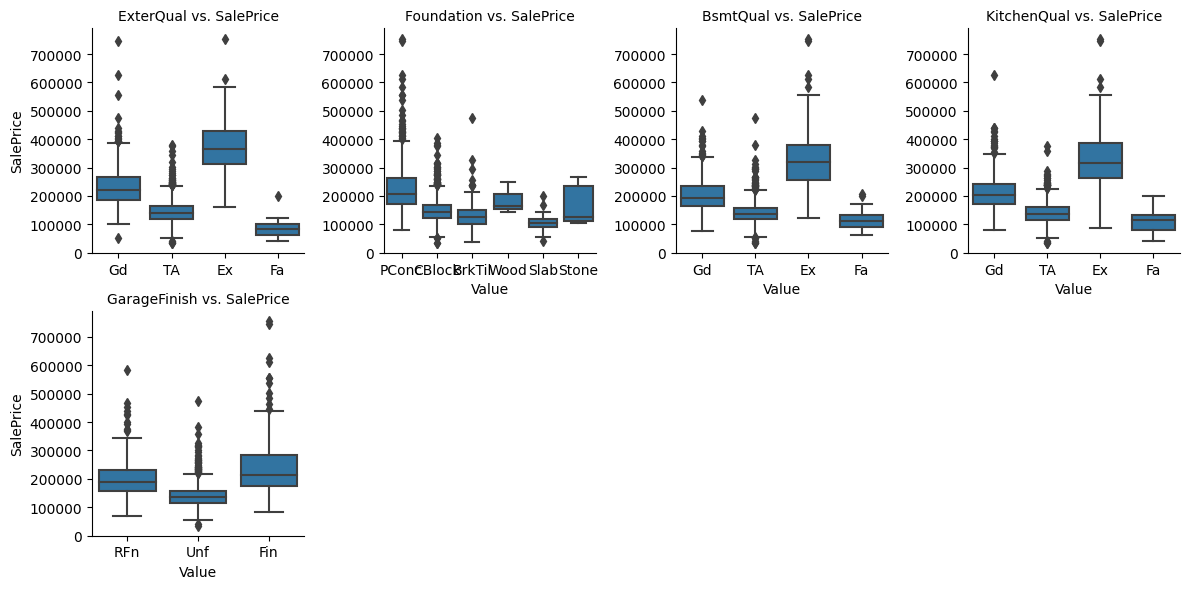

In [13]:
# Melt the DataFrame into long-format
td_melted_cat = td.melt(id_vars=['SalePrice'], value_vars = top_categorical_features, var_name = 'Feature', value_name = 'Value')

# Now use the melted DataFrame
g = sns.FacetGrid(td_melted_cat, col_wrap=4, col="Feature", sharex=False, sharey=False)
g.map_dataframe(sns.boxplot, x="Value", y = 'SalePrice')
g.set_titles("{col_name} vs. SalePrice")
g.fig.tight_layout()
plt.show()

Based on the above output, the categorical variables that affect a house's sale price the most seem to be `ExterQual`, `BsmtQual`, and `KitchenQual`. These three features have the highest F-statistics from the ANOVA tests, and also show clear differences in `SalePrice` in the above boxplots. Now that we've narrowed down the most important features for predicting `SalePrice`, we can move onto the modeling phase.

# Section 3 - Modeling

## Step 1 - Data Preprocessing

Before we can get into choosing a model, we must prepare our training data. First, we'll drop all unimportant columns from the `train` dataset. Then, we'll perform a z-score standardization on all of our continuous features to give them all the same scale. Finally, we'll use the pandas `get_dummies()` method to get dummy variables for all categorical variables:

In [14]:
# Import libraries for data preprocessing
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Create new training dataframe with only most important features
features = top_numeric_features + top_categorical_features + ['SalePrice']
print(train.columns)
train = train[features]

# Perform a z-score standardization on all top numeric features
numeric_features = top_numeric_features + ['SalePrice']
train.loc[:, numeric_features] = scaler.fit_transform(train[numeric_features])

# Set prediction target and remove SalePrice
y = train['SalePrice']

# Check the mean and std dev of the scaled columns
print(train[top_numeric_features].mean(axis=0))  # Should be close to 0
print(train[top_numeric_features].std(axis=0))   # Should be close to 1

# Get dummies for categorical features, and set our X
X = pd.get_dummies(train, columns = top_categorical_features, drop_first = True)
print(X.head())

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Step 2 - Modeling and Validation

Now that we have our features and prediction target set, we are good to begin the modeling phase. We will try out the following algorithms:

1. **RidgeCV** - Since we have a large amount of features, we will want to use L2 regularization with a linear regression model. We'll use the cross-validation version of this algorithm so that we can automatically choose the weight for our penalty. ($\lambda$)

2. **Support Vector Machines (SVM)** - If we don't decrease the number of features through regularization, we can try to use Support Vector Machines due to the high dimensionality of the training data.

3. **Multilayer Perceptron Regressor** - To be honest, I just want to try out a neural network and see how it goes!

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV    # L2 Regularization Linear Regression with built-in cross-validation
from sklearn import svm   # Support Vector Machines
from sklearn.neural_network import MLPRegressor    # Multilayer Perceptron Regressor
from sklearn.model_selection import cross_val_score, KFold    # K-fold Cross-Validation

# Split the training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# ---------- MODEL 1 - RidgeCV ----------

print("--------------------")
print("Model 1 - Ridge Regression")
print("--------------------\n")

# Initialize RidgeCV
alpha_choices = [0.01, 0.1, 1.0, 10.0, 100.0]
ridge_cv_model = RidgeCV(alphas = alpha_choices, store_cv_values = True)

# Fit the RidgeCV model on the training data
ridge_cv_model.fit(X_train, y_train)

# Get mean MSE across each fold of cross-validation
mean_cv_mse = np.mean(ridge_cv_model.cv_values_, axis=0)

# Print the results
for alpha, mse in zip(alpha_choices, mean_cv_mse):
    print(f"Alpha: {alpha:.6f} -> MSE: {mse:.2f}")
    
# ---------- MODEL 2 - LinearRegression ----------

print("\n--------------------")
print("Model 2 - Linear Regression")
print("--------------------\n")

# Initialize the Linear Regression model
linear_model = LinearRegression()

# Define a KFold cross-validation strategy
cv = KFold(n_splits=10, shuffle=True, random_state=0)

# Use cross_val_score to evaluate the model using the defined strategy and MSE as the scoring method
mse_scores_lin_reg = cross_val_score(linear_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)

# Since cross_val_score returns negative MSE scores (because it's a utility function where higher is better),
# we will convert them to positive MSE scores for easier interpretation.
mse_scores_lin_reg = -mse_scores_lin_reg

# Print results
print("MSE scores from each fold: ", mse_scores_lin_reg)
print("Average MSE across all folds: ", np.mean(mse_scores_lin_reg))
print("Standard Deviation of MSE across all folds: ", np.std(mse_scores_lin_reg))

# ---------- MODEL 3 - MLPRegressor ----------

print("\n--------------------")
print("Model 3 - Multilayer Perceptron Regressor")
print("--------------------\n")

# Initialize the MLP and fit it to the data
mlp_model = MLPRegressor(random_state = 0, max_iter = 500)
mlp_model.fit(X_train, y_train)

# Print out the score of the Neural Net, and calculate the MSE
mse_scores_mlp = cross_val_score(mlp_model, X_train, y_train, scoring='neg_mean_squared_error', cv=cv)
mse_scores_mlp = -mse_scores_mlp

# Print results
print("MSE scores from each fold: ", mse_scores_mlp)
print("Average MSE across all folds: ", np.mean(mse_scores_mlp))
print("Standard Deviation of MSE across all folds: ", np.std(mse_scores_mlp))

--------------------
Model 1 - Ridge Regression
--------------------

Alpha: 0.010000 -> MSE: 0.00
Alpha: 0.100000 -> MSE: 0.00
Alpha: 1.000000 -> MSE: 0.00
Alpha: 10.000000 -> MSE: 0.00
Alpha: 100.000000 -> MSE: 0.02

--------------------
Model 2 - Linear Regression
--------------------

MSE scores from each fold:  [7.22452330e-31 4.97348332e-30 3.65608640e-31 2.14497693e-30
 1.48360168e-30 1.26388199e-29 4.37708273e-30 1.08027218e-29
 3.77314990e-30 3.81811093e-30]
Average MSE across all folds:  4.51000082481631e-30
Standard Deviation of MSE across all folds:  3.914129816059649e-30

--------------------
Model 3 - Multilayer Perceptron Regressor
--------------------

MSE scores from each fold:  [0.00524886 0.00632632 0.00768061 0.00513064 0.00541341 0.00464033
 0.00560869 0.01215347 0.0062716  0.00553665]
Average MSE across all folds:  0.006401057917035997
Standard Deviation of MSE across all folds:  0.0020770652956248184


Based on our above output, we will use a Linear Regression model for our final submission. Below, we predict the values for our test data using the linear regression model we created above, output the results to a CSV, and check whether or not it was successful:

In [16]:
# TODO: Undo z-score scaling on the 'SalePrice' variable to get accurate predictions
# Calculate the mean and standard deviation of SalePrice
price_mean = train['SalePrice'].mean()
price_std = train['SalePrice'].std()

# Fit linear regression model and generate predictions
linear_model.fit(X, y)
# predictions = linear_model.predict()

# Output predictions into submission.csv
# output = pd.DataFrame({'Id': test.Id, 'SalePrice': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

LinearRegression()